![](TikTok.jpg)
# TikTok Video Classification Project: Logistic Regression
*Purpose*\
TikTok is a platform for producing and viewing short-term mobile videos. Users of the platform can report videos and comments that contain claims versus opinions. With the high number of submissions and interactions on TikTok each day, it is challenging for human moderators to review efficiently each video, comments, and claims concerning content. TikTok wants to reduce the backlog of user reports and prioritize claim reports. **The goal of this project is to mitigate misinformation in videos on the TikTok platform by building a reliable machine learning model which will help reduce report backlog**.

* An *opinion* is a personal or group belief or thought concerning any information, action, thought, person, or group, place, or thing
* A *claim* is unqualified information concerning any information, action, thought, person, or group, place, or thing

As presented by TikTok: “any answers, responses, comments, opinions, analysis or recommendations that you are not properly licensed or otherwise qualified to provide (https://www.tiktok.com/legal/page/us/terms-of-service/en ).” \
TikTok safety: https://newsroom.tiktok.com/en-us/safety

*Deliverables*
>**Notebook Part II: Binomial logistic regression model**\
This section contains a binomial logistic regression model built to predict whether a posted video comes from a verified or not verified author. EDA results suggest that if a video is posted by a verified author, it is more likely to contain an opinion. The built model provides a ranking of how different variables are associated with whether a user is verified (the feature `verified_status`); how video characteristics relate to `verified_status`. Of particular interest is the predictive power of the feature `claim_status`. `claim_status` labels videos as either claims or opinions.

*Data*\
The data set used here comes from the Google Advanced Data Analytics Professional Certificate course on the Coursera platform: https://www.coursera.org/google-certificates/advanced-data-analytics-certificate

*Code and Report*\
All code and reports for this project is located at: https://github.com/izsolnay/TikTok_Python

In [1]:
# Import standard operational packages
import pandas as pd
import numpy as np

# Import packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set grid for all plots
sns.set(style='whitegrid')

# Import packages for resampling
from sklearn.utils import resample

# Import packages for logistic regression 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Import packages for evaluation and testing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set Jupyter to display all of the columns (no redaction)
pd.set_option('display.max_columns', None)

# Suppress warnings
import warnings

In [2]:
# Import data; create df
df0 = pd.read_csv('TikTok_clean.csv')
df0.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175


# PART IIa: Binomial logistic regression model based on multiple variables.
A binomial logistic model (rather than linear) is appropriate because it is a statistical technique that models the probability of an event (verification status) based on one (or more) independent variables. The outcome must be a binary classification. In this case: verified or not verified. 

In order to confirm that a binomial regression model is best, first a review of the df must be performed:
* missing data
* potential outliers
  * regression models are sensitive to outliers, so should be dropped, capped, or replaced with medians or means
* duplicates - this was covered in PART I: EDA
* check for multicollinearity
* identify data anomalies such as class imbalance that might affect the modeling

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
 12  likes_per_view            19084 non-null  float64
 13  comments_per_view         19084 non-null  float64
 14  shares

In [4]:
df0.describe().apply(lambda x: x.apply('{0:.2f}'.format)) # Apply ''.format to suppresses scientific notation

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
count,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00
mean,9542.50,5624839917.87,32.42,254708.56,84304.64,16735.25,1049.43,349.31,0.28,0.00,0.05
std,5509.22,2537030180.26,16.23,322893.28,133420.55,32036.17,2004.30,799.64,0.17,0.00,0.05
min,1.00,1234959018.00,5.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4771.75,3425100251.25,18.00,4942.50,810.75,115.00,7.00,1.00,0.13,0.00,0.01
50%,9542.50,5609500370.00,32.00,9954.50,3403.50,717.00,46.00,9.00,0.26,0.00,0.04
75%,14313.25,7840823300.50,47.00,504327.00,125020.00,18222.00,1156.25,292.00,0.40,0.00,0.08
max,19084.00,9999873075.00,60.00,999817.00,657830.00,256130.00,14994.00,9599.00,0.67,0.01,0.27


## EDA and transformations
* initial df transformations: dropping rows and/or columns
* gather further statistics: creation of features and/or visualizations

In [5]:
# Drop columns which will not be useful 
df = df0.drop(columns = ['#', 'video_id'])

In [6]:
# Check rows with missing data 
df.isna().sum()

claim_status                0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
likes_per_view              0
comments_per_view           0
shares_per_view             0
dtype: int64

In [7]:
# Check class balance
# Get value counts for categorical 'claim_status' to establish how many/percentage videos in each category
counts = df['verified_status'].value_counts()
percentages = df['verified_status'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%' # Round percentage and show as string with % sign

result = pd.DataFrame({'Counts': counts, 'Percentage': percentages}).reset_index()
result.style.background_gradient()

,verified_status,Counts,Percentage
0,not verified,17884,93.7%
1,verified,1200,6.3%


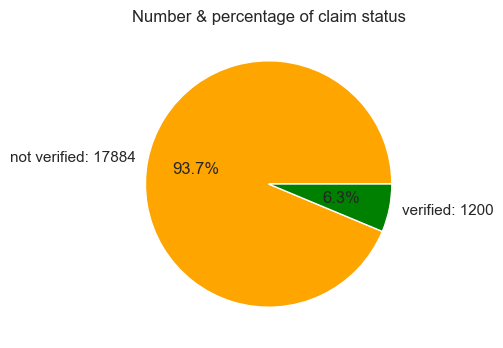

In [8]:
# Pie chart for claim_status by verified_status
fig = plt.figure(figsize=(4,4))
data=df['verified_status'].value_counts()

plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%', colors=['orange', 'green']
        )
plt.title('Number & percentage of claim status');

Result\
There is a heavy imbalance of the outcome variable `verified_status`. It will need to be rebalanced.

### Transformation
* outliers
* resampling
* new features
* encode variables

### Outliers
As determined from the EDA (PART I), many variables have outliers. Regression models cannot handle outliers, so these have to be dealt with.\
These outliers do not seem to be data entry errors; they are present because of the right-skewed distributions.   

In [9]:
print(df.shape)
df.columns

(19084, 13)


Index(['claim_status', 'video_duration_sec', 'video_transcription_text',
       'verified_status', 'author_ban_status', 'video_view_count',
       'video_like_count', 'video_share_count', 'video_download_count',
       'video_comment_count', 'likes_per_view', 'comments_per_view',
       'shares_per_view'],
      dtype='object')

In [10]:
# Calculate # of outliers for variables
count_cols = ['video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 
              'video_comment_count', 'likes_per_view', 'comments_per_view', 'shares_per_view']

for column in count_cols:                    # Calculate IQR for all variables
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    median = df[column].median()         # Calculate median for all variables
    outlier_threshold = median + 1.5 * iqr     # Set threshold for all variables

    # Count the number of values that exceed the outlier threshold
    outlier_count = (df[column] > outlier_threshold).sum()
    print(f'# of outliers for {column}:', outlier_count)

# of outliers for video_view_count: 2343
# of outliers for video_like_count: 3468
# of outliers for video_share_count: 3732
# of outliers for video_download_count: 3733
# of outliers for video_comment_count: 3882
# of outliers for likes_per_view: 4
# of outliers for comments_per_view: 2435
# of outliers for shares_per_view: 1471


#### Visualize Outliers: Create box plots
Box plots are a method of displaying the distribution of data based on a 5-number summary: min, 1st quartile, median, 3rd quartile, & max.\
Whiskers of box plots typically extend to 1.5x the interquartile range (IQR) from the 1st and 3rd quartiles. 

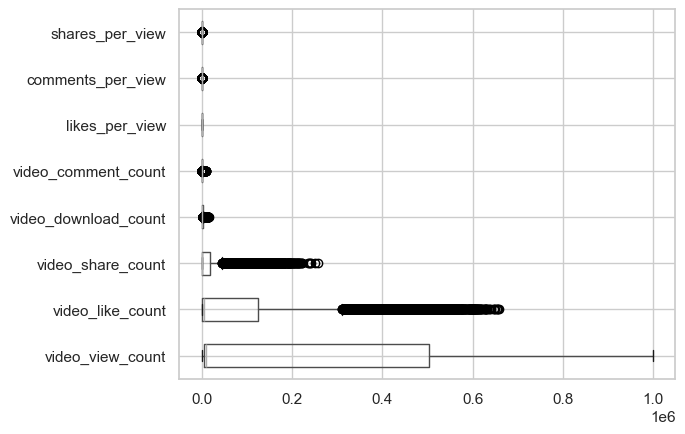

In [11]:
df.boxplot(['video_view_count', 'video_like_count', 'video_share_count', 
            'video_download_count', 'video_comment_count', 'likes_per_view', 
            'comments_per_view', 'shares_per_view'], vert=False)                 # vert=False for horizontal arragement
plt.show()

#### 1st try: Cap values at 95th percentile
* create copy of df to see if this method will prove adequate
* for each column in the list [''], calculate 95th percentile of data - iterate
* any values in a column that are > than their 95th percentile, replace with 95th percentile value

In [12]:
# See if capturing 95% will make the difference. Exclude likes_per_view and video_view_count
df_outliers = df.copy()

# Impute outliers
for column in ['video_like_count', 'video_share_count', 'video_download_count',
               'video_comment_count', 'comments_per_view', 'shares_per_view']:        # Iterate over columns
    
    percentile95 = df_outliers[column].quantile(0.95)                                 # Calculate 95%
    
    df_outliers.loc[df_outliers[column] > percentile95, column] = percentile95        # Replace values above 95%

In [13]:
df_outliers.describe().round(2)

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
count,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.0,19084.00
mean,32.42,254708.56,80008.46,14917.13,934.57,286.05,0.28,0.0,0.05
std,16.23,322893.28,120655.16,25415.98,1584.10,530.18,0.17,0.0,0.05
min,5.00,20.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,18.00,4942.50,810.75,115.00,7.00,1.00,0.13,0.0,0.01
50%,32.00,9954.50,3403.50,717.00,46.00,9.00,0.26,0.0,0.04
75%,47.00,504327.00,125020.00,18222.00,1156.25,292.00,0.40,0.0,0.08
max,60.00,999817.00,393957.30,89017.50,5547.85,1921.00,0.67,0.0,0.16


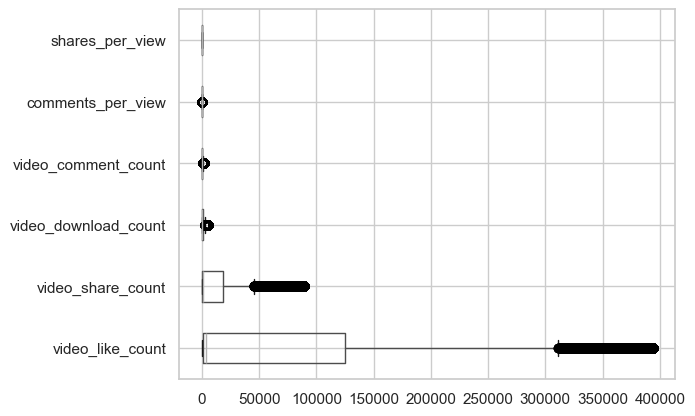

In [14]:
df_outliers.boxplot(['video_like_count', 'video_share_count', 'video_download_count', 
                     'video_comment_count', 'comments_per_view', 'shares_per_view'], vert=False)
plt.show() 

Result   
Capping at 95% did not address most of the outliers. A more robust method is needed.

#### 2nd try: Calculate Interquartile Range (IQR) to identify outliers
* for each column in the list [''], calculate 25th and 75th percentiles of data in each column - iterate
* then calculate IQR (75th - 25th percentiles)
* calculate upper limit (1.5 * IQR + 75th percentile)
* replace any value > than upper limit with associated upper limit value

In [15]:
# Calculate # of outliers for variables
outlier_cols = ['video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 
              'video_comment_count', 'likes_per_view', 'comments_per_view', 'shares_per_view']

for column in outlier_cols:                    # Calculate IQR for all variables
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    outlier_threshold = q3 + 1.5 * iqr     # Set threshold for all variables

    # Cap outliers
    df.loc[df[column] > outlier_threshold, column] = outlier_threshold

In [16]:
df.describe().round(2)

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view
count,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.00,19084.0,19084.00
mean,32.42,254708.56,74323.54,11246.91,713.44,181.02,0.28,0.0,0.05
std,16.23,322893.28,107103.56,16573.53,1049.88,272.08,0.17,0.0,0.05
min,5.00,20.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,18.00,4942.50,810.75,115.00,7.00,1.00,0.13,0.0,0.01
50%,32.00,9954.50,3403.50,717.00,46.00,9.00,0.26,0.0,0.04
75%,47.00,504327.00,125020.00,18222.00,1156.25,292.00,0.40,0.0,0.08
max,60.00,999817.00,311333.88,45382.50,2880.12,728.50,0.67,0.0,0.18


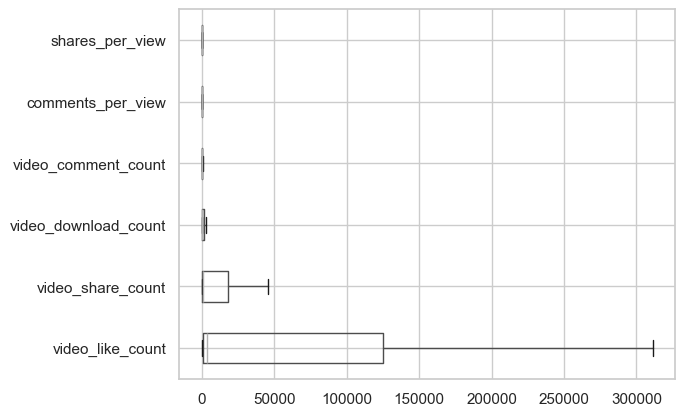

In [17]:
df.boxplot(['video_like_count', 'video_share_count', 
            'video_download_count', 'video_comment_count',
            'comments_per_view', 'shares_per_view'], vert=False)
plt.show()  

Result\
By using the more IQR to identify outliers and then replacing them, a broader range of potential outliers was captured compared to capping values at the 95th percentile.\
This more robust method captured more outliers that lie further away from the median. 

### Resampling
Feature `verified_status` is heavily imbalanced. ~93.7%% of videos are by unverified authors (majority) & 6.3% by verified authors (minority). 

For this model, the minority class will be upsampled. Random copies of observations from the minority class will be added to the dataset.

Downstream problems:\
By resampling the class distribution the trained model may predict the minority class too much - more than with unseen data.\
In order to test the model more accurately, it might be good to split the train/test set before resampling.

In [18]:
# Check class balance
# Get value counts for categorical 'claim_status' to establish how many/percentage videos in each category
counts = df['verified_status'].value_counts()
percentages = df['verified_status'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

result = pd.DataFrame({'counts': counts, 'percentage': percentages}).reset_index()
result.style.background_gradient()

,verified_status,counts,percentage
0,not verified,17884,93.7%
1,verified,1200,6.3%


In [19]:
# Create class balance in the outcome variable by resampling
# Subset majority and minority classes
df_maj = df[df['verified_status']== 'not verified']
df_min = df[df['verified_status']== 'verified']

# Upsample minority class to match majority
df_min_upsampled = resample(df_min,
                                 replace=True,                 # replace=True is sample with replacement
                                 n_samples=len(df_maj),        # len(df_maj) matches majority class in size
                                 random_state=0)

# Join df_maj and upsampled df_min_upsampled
upsampled = pd.concat([df_maj, df_min_upsampled]).reset_index(drop=True)

# Display new class counts
upsampled['verified_status'].value_counts()

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

### Create new variable `text_length` for new df upsampled

In [20]:
# Create `text_length` column
upsampled['text_length'] = upsampled['video_transcription_text'].str.len()
upsampled.head(2)

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
0,claim,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97
1,claim,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.003023,0.135111,107


In [21]:
# Calculate median & average text length by verification status
mean_values = upsampled.groupby(by='verified_status')[['text_length']].mean(numeric_only=True).round(1)
median_values = upsampled.groupby(by='verified_status')[['text_length']].median(numeric_only=True).round(1)

# Combine mean and median into a single DataFrame
result = mean_values.rename(columns={'text_length': 'mean_text_length'})
result['median_text_length'] = median_values

result

,mean_text_length,median_text_length
verified_status,,
not verified,89.4,87.0
verified,84.6,82.0


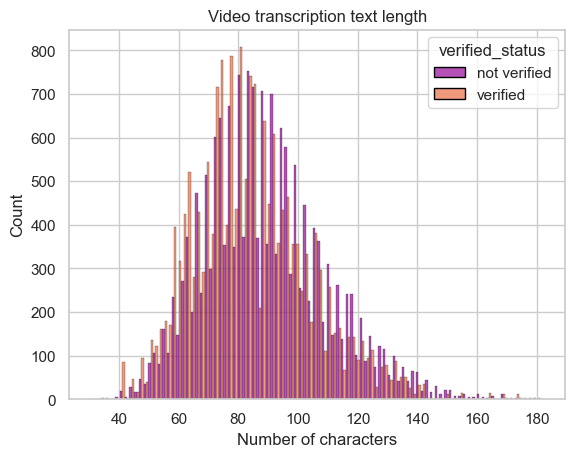

In [22]:
# Create histogram to view distribution of `video_transcription_text` length by verification
sns.histplot(data=upsampled, 
             stat='count', 
             x='text_length', 
             multiple='dodge',    # Place counts of each side by side 
             palette='plasma', 
             edgecolor = 'black', 
             hue='verified_status')

plt.xlabel('Number of characters')
plt.title('Video transcription text length')

plt.show()

In [23]:
# Create new csv file for modified df
upsampled.to_csv('TikTok_resampled.csv', index=False)
df = pd.read_csv('TikTok_resampled.csv')
df.head()

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
0,claim,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97
1,claim,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.003023,0.135111,107
2,claim,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137
3,claim,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131
4,claim,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128


### Check data for modelling
Determine whether assumptions have been met for logistic regression:
* independent observations: this is assumed
* no extreme outliers: addressed above
* little to no multicollinearity among X predictors (Pearson correlation coefficient matrix)
* linear relationship between X and the logit of y: after modelling

#### Collinearity
* calculate variance inflation factor (VIF)
* generate a Pearson correlation coefficient matrix

In [24]:
df.columns

Index(['claim_status', 'video_duration_sec', 'video_transcription_text',
       'verified_status', 'author_ban_status', 'video_view_count',
       'video_like_count', 'video_share_count', 'video_download_count',
       'video_comment_count', 'likes_per_view', 'comments_per_view',
       'shares_per_view', 'text_length'],
      dtype='object')

In [25]:
# Calculate the variance inflation factor
# Create subset of data 
data = df[['video_duration_sec', 'video_view_count', 'video_like_count',
           'video_share_count', 'video_download_count', 'video_comment_count',
           'likes_per_view', 'comments_per_view', 'shares_per_view', 'text_length']]

# Calculate the variance inflation factor for each variable
vif = [variance_inflation_factor(data.values, i) 
       
       for i in range(data.shape[1])]

# Put VIF results into new df
df_vif = pd.DataFrame(vif, index = data.columns, columns=['VIF'])

df_vif.sort_values(by='VIF', ascending=False)

,VIF
video_like_count,15.690910
likes_per_view,11.325599
video_download_count,10.830607
video_comment_count,10.229234
video_share_count,9.221466
video_view_count,7.140709
text_length,6.964312
shares_per_view,6.053189
video_duration_sec,4.229649
comments_per_view,4.217420


Results\
VIF quantifies how correlated each independent variable (X) is with all the other independent variables (Xs). Or, how much the variance of each variable is inflated due to correlation with other X variables. A model with high variance can overfit to the observed data and generate inaccurate estimates for unseen data. The larger the VIF, the more multicollinearity there is in the model.

VIF of 1 = 0 correlation between the X variable & the other predictor variables (Xs) in the model.
VIFs above 5, 10, or even 30 are considered potentially high multicollinearity. 

Here
* most collinearity: `video_like_count` at ~16
* and `likes_per_view`, `video_download_count`, and `video_comment_count` at ~10-11


In [26]:
# Generate a Pearson correlation coefficient matrix
correlation_matrix = df.corr(method='pearson', numeric_only=True)
correlation_matrix

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
video_duration_sec,1.000000,0.013589,0.004494,0.001875,0.008972,-0.001086,-0.003731,-0.023341,0.000737,-0.002981
video_view_count,0.013589,1.000000,0.856937,0.794957,0.782352,0.748361,0.278638,0.290526,0.200682,0.244693
video_like_count,0.004494,0.856937,1.000000,0.888427,0.873458,0.818032,0.565200,0.432313,0.398245,0.216693
video_share_count,0.001875,0.794957,0.888427,1.000000,0.803551,0.766203,0.493008,0.400953,0.531227,0.208529
video_download_count,0.008972,0.782352,0.873458,0.803551,1.000000,0.911894,0.488889,0.558533,0.346842,0.216871
video_comment_count,-0.001086,0.748361,0.818032,0.766203,0.911894,1.000000,0.455890,0.643946,0.327374,0.217661
likes_per_view,-0.003731,0.278638,0.565200,0.493008,0.488889,0.455890,1.000000,0.559737,0.675239,0.094428
comments_per_view,-0.023341,0.290526,0.432313,0.400953,0.558533,0.643946,0.559737,1.000000,0.402385,0.114256
shares_per_view,0.000737,0.200682,0.398245,0.531227,0.346842,0.327374,0.675239,0.402385,1.000000,0.061186
text_length,-0.002981,0.244693,0.216693,0.208529,0.216871,0.217661,0.094428,0.114256,0.061186,1.000000


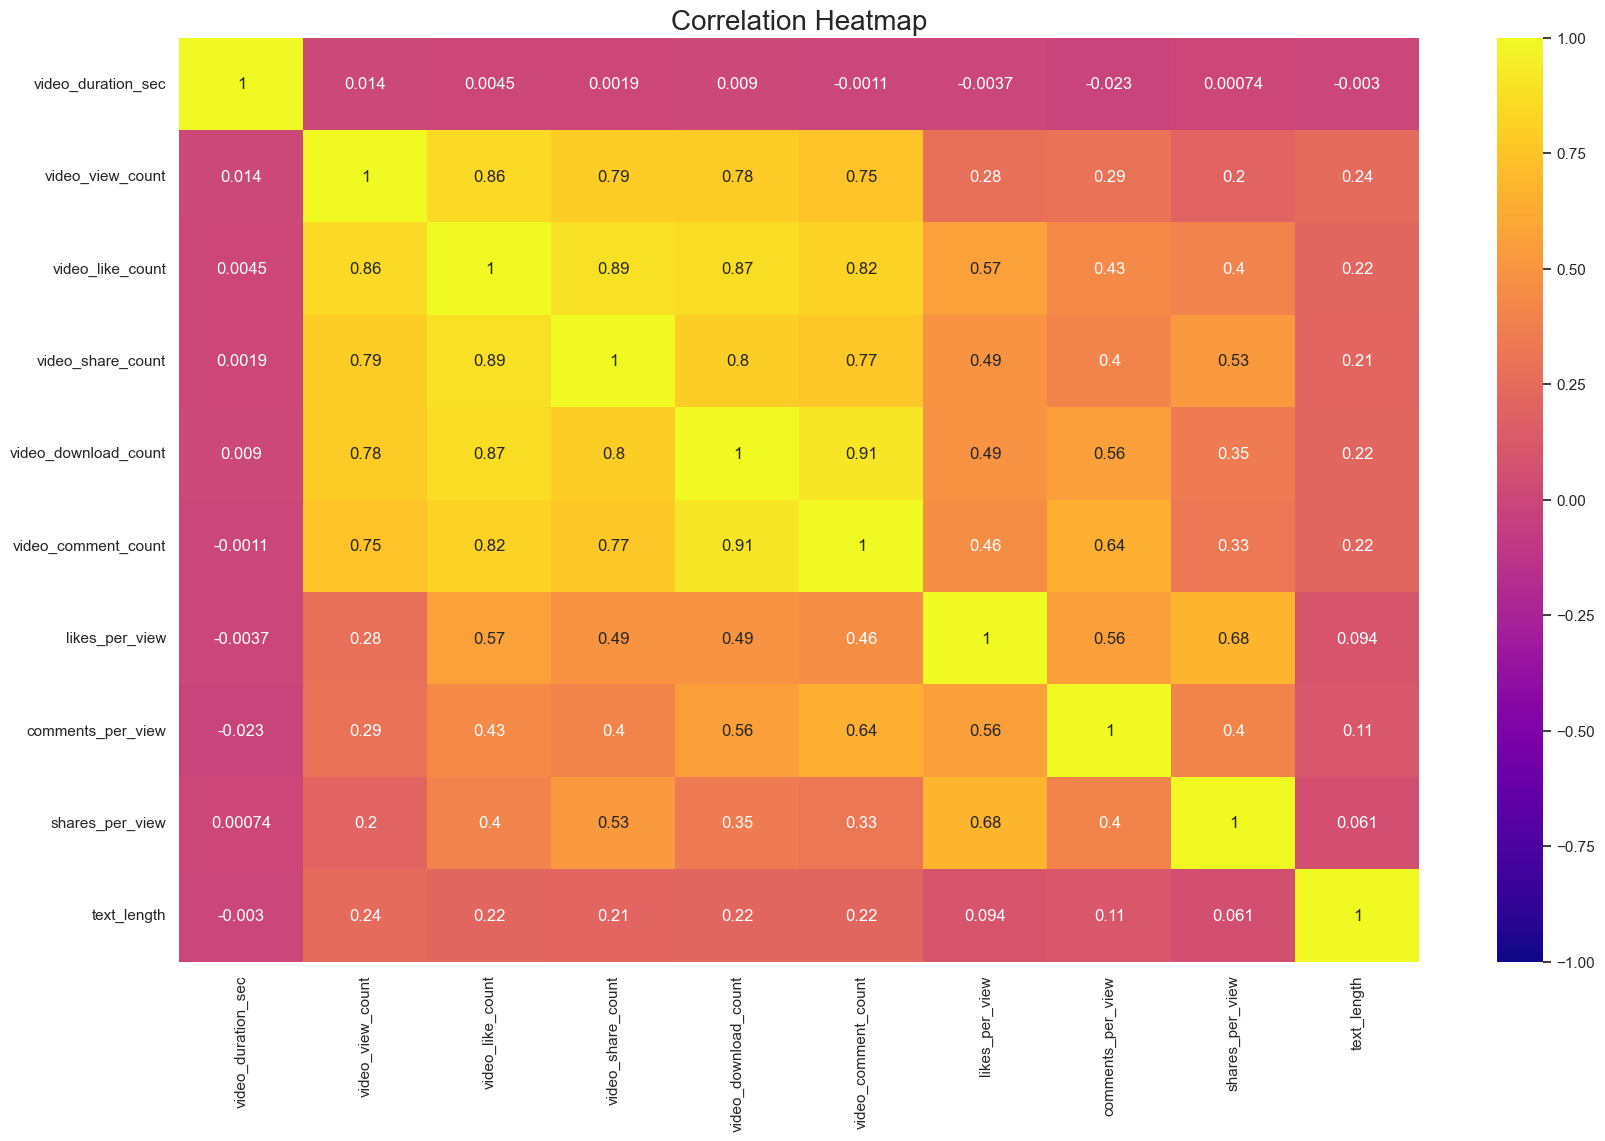

In [27]:
# Plot correlation heatmap
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='plasma')
plt.title('Correlation Heatmap', fontsize=20)
plt.show();

Results\
A Pearson correlation coefficient value > the absolute value of 0.7, are strongly multicollinear variables and only one of these variables should be used.

Strong multicollinearity:\
`video_view_count`, `video_like_count`, `video_share_count`, `video_download_count`, and `video_comment_count` are all heavily correlated with each other. Most correlated: `video_download_count` and `video_comment_count` AND `video_comment_count` and `video_share_count`

Also, strongly correlated: `video_like_count` and `video_share_count` with `video_like_count` slightly more.

#### Results
Both VIF and the correlation matrix indict that by removing the problematic `video_like_count`, `video_download_count`, and `video_comment_count` the strongest multicollinearity should be removed.


To be removed from X variable:
* for multicollinearity: `video_like_count`, `video_download_count`, and `video_comment_count`
* this is the target: `verified_status`

### Encode variables `claim_status`, `verified_status`, and `author_ban_status`

In [28]:
print(df['claim_status'].unique())
print(df['verified_status'].unique())
print(df['author_ban_status'].unique())

['claim' 'opinion']
['not verified' 'verified']
['under review' 'active' 'banned']


In [29]:
# Create subset df to encode
to_encode = df[['claim_status', 'author_ban_status', 'verified_status']]
to_encode.head(2)

,claim_status,author_ban_status,verified_status
0,claim,under review,not verified
1,claim,active,not verified


In [30]:
encoded = pd.get_dummies(to_encode, dtype=int, drop_first=True) 
encoded.head(2)

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review,verified_status_verified
0,0,0,1,0
1,0,0,0,0


Results\
0 (FALSE) or 1 (TRUE)\
claim_status_opinion >
* 1 opinion
* 0 claim
  
author_ban_status > 
* 1/0 author_ban_status_banned
* 0/1 author_ban_status_under review
* 0/0 active

**verified_status_verified** > 
* 1 verified
* 0 not verified

In [31]:
# Concatenate df and encoded 
df_encoded = pd.concat([df.drop(columns=['claim_status', 'author_ban_status', 'verified_status']).reset_index(drop=True), encoded], axis=1)
df_encoded.head(2)

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,claim_status_opinion,author_ban_status_banned,author_ban_status_under review,verified_status_verified
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1,0
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.003023,0.135111,107,0,0,0,0


In [32]:
# Create new csv file for modified df
df_encoded.to_csv('TikTok_encoded.csv', index=False)
df = pd.read_csv('TikTok_encoded.csv')
df.head(2)

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,claim_status_opinion,author_ban_status_banned,author_ban_status_under review,verified_status_verified
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,0,0,1,0
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.003023,0.135111,107,0,0,0,0


### Prepare data for modelling
* Split the data into:
  * features and target variable
  * training data(75%) and test data(25%)
  * no need to stratify, because data set is rebalanced
  * set a random seed so work can be reproduced (42)

In [33]:
# Subset independent X and dependent y
# Isolate predictor variables by dropping problematic variables (string, collinear, and target)
X = df.drop(columns = ['video_transcription_text', 'video_like_count', 'verified_status_verified', 'video_download_count', 'video_comment_count'])

# Isolate target variable
y = df['verified_status_verified']

In [34]:
# Check variables
print('X')
print(X.info())
print('y')
print(y.info())

X
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35768 entries, 0 to 35767
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   video_duration_sec              35768 non-null  int64  
 1   video_view_count                35768 non-null  float64
 2   video_share_count               35768 non-null  float64
 3   likes_per_view                  35768 non-null  float64
 4   comments_per_view               35768 non-null  float64
 5   shares_per_view                 35768 non-null  float64
 6   text_length                     35768 non-null  int64  
 7   claim_status_opinion            35768 non-null  int64  
 8   author_ban_status_banned        35768 non-null  int64  
 9   author_ban_status_under review  35768 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 2.7 MB
None
y
<class 'pandas.core.series.Series'>
RangeIndex: 35768 entries, 0 to 35767
Series name: verified_stat

In [35]:
# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [36]:
# Check X_train df
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 10), (8942, 10), (26826,), (8942,))

In [37]:
# Check balance of training set
y_train.value_counts()
print(y_train.value_counts(normalize=True))

verified_status_verified
0    0.501267
1    0.498733
Name: proportion, dtype: float64


In [38]:
# Check balance of test set
y_test.value_counts()
print(y_test.value_counts(normalize=True))

verified_status_verified
1    0.503802
0    0.496198
Name: proportion, dtype: float64


## Build Model and plot logistic regression classification model
* instantiate model
* fit model
* get coefficients (parameter and intercept [betas]) for regplots   
(Coefficients represent change in log odds of the target variable(y) for every 1 unit increase in X.

In [39]:
# Instantiate and fit the model
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train, y_train)

In [40]:
# Get coefficients 
print('Intercept', log_clf.intercept_)

# Create attractive list
pd.Series(log_clf.coef_[0], index=X_train.columns)

Intercept [-0.60289111]


video_duration_sec               -2.858508e-03
video_view_count                 -6.121497e-07
video_share_count                 1.553621e-05
likes_per_view                   -4.524293e-01
comments_per_view                -2.021493e-03
shares_per_view                  -6.144475e-02
text_length                      -1.975691e-03
claim_status_opinion              1.523851e+00
author_ban_status_banned         -5.588932e-01
author_ban_status_under review   -2.228794e-01
dtype: float64

#### Create regplots to check for log-odds (probabilities) linearity
* create new variable training_probabilities
  * call predict_proba() to generate the probability of response for each sample in the training data 
  * result is a 2-D array where each row represents a user in X_train
      * 1st column is the probability of the video being posted by a not verified author 
      * 2nd column is the probability of the video being posted by a verified author 
* create new variable logit in the logit_data dataframe which represents the logit for each user

In [41]:
# Get the predicted probabilities of the training data
training_probabilities = log_clf.predict_proba(X_train)
training_probabilities

array([[0.36534139, 0.63465861],
       [0.36755497, 0.63244503],
       [0.67212196, 0.32787804],
       ...,
       [0.39840497, 0.60159503],
       [0.78552903, 0.21447097],
       [0.37279693, 0.62720307]])

In [42]:
X_train.dtypes

video_duration_sec                  int64
video_view_count                  float64
video_share_count                 float64
likes_per_view                    float64
comments_per_view                 float64
shares_per_view                   float64
text_length                         int64
claim_status_opinion                int64
author_ban_status_banned            int64
author_ban_status_under review      int64
dtype: object

In [43]:
# Copy X_train and assign to logit_data
logit_data = X_train.copy()

# Create a new `logit` variable in `logit_data` df which represent the logit (% chance) for each user
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]  # np.log(ARRAY) will compute log(x) 
                                     # np.log(x) calculates natural logarithm of a given input; how close the odds of X go to either 1 or 0
                                                               

#### Regplots
Plot for each continuous or discrete predictor variable to check for linearity of logit.    
Where the x-axis represents an independent variable and the y-axis represents the log-odds of the predicted probabilities    
plot each continuous and discrete predictor variable:

* discrete (int64): `claim_status_opinion`, `author_ban_status_banned`, `author_ban_status_under review`, `video_duration_sec`, and `text_length`
  * binaries `claim_status_opinion`, `author_ban_status_banned`, and `author_ban_status_under review` will not be plotted
* continuous (float64): `video_view_count`, `video_share_count`, `video_comment_count`, `likes_per_view`, `comments_per_view`, `shares_per_view`


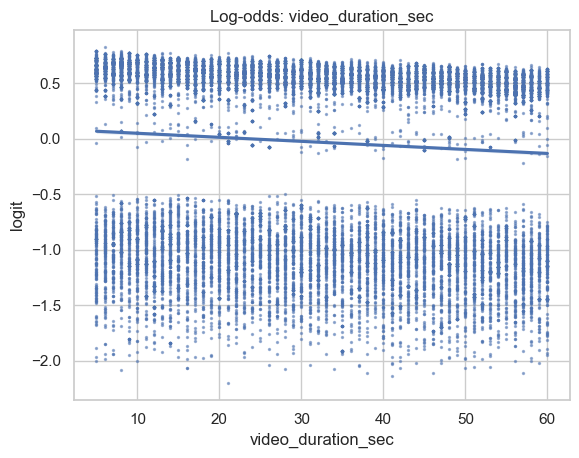

In [44]:
sns.regplot(x='video_duration_sec', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: video_duration_sec');

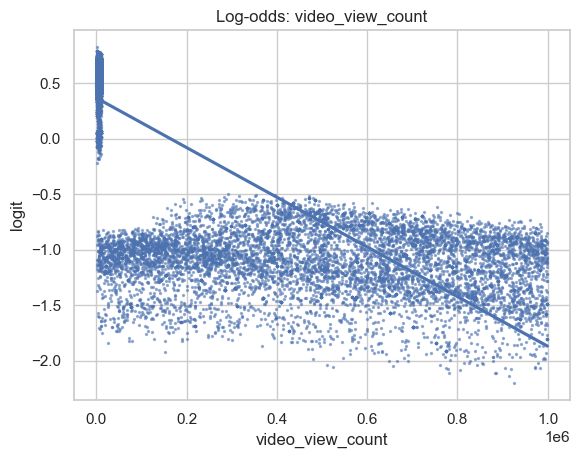

In [45]:
sns.regplot(x='video_view_count', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: video_view_count');

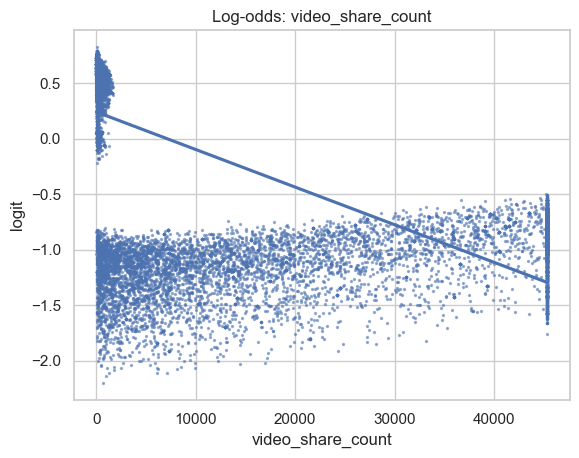

In [46]:
sns.regplot(x='video_share_count', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: video_share_count');

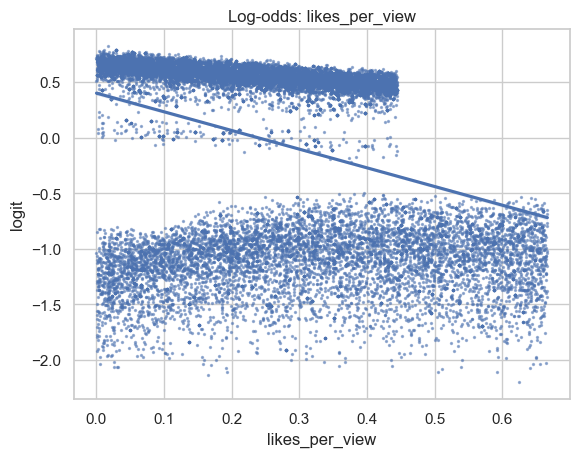

In [47]:
sns.regplot(x='likes_per_view', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: likes_per_view');

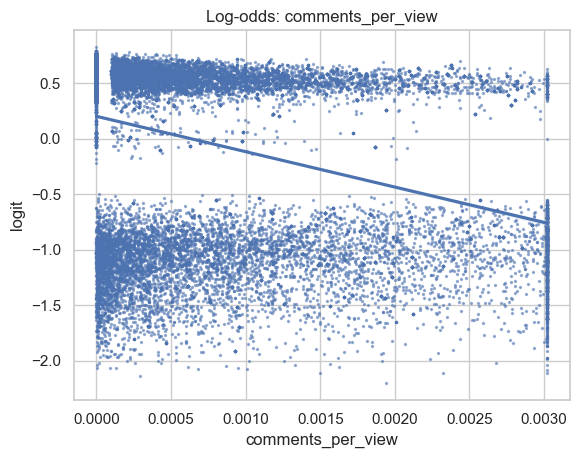

In [48]:
sns.regplot(x='comments_per_view', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: comments_per_view');

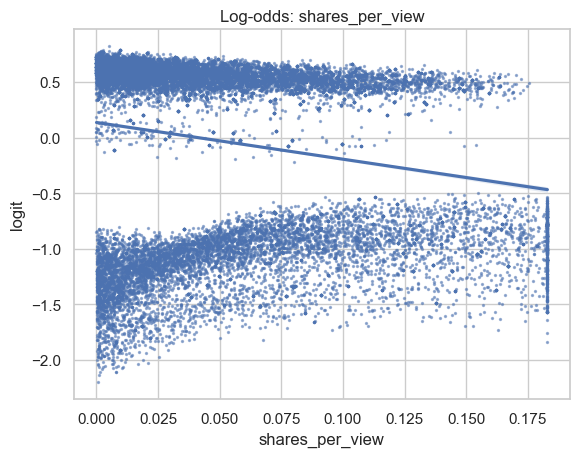

In [49]:
sns.regplot(x='shares_per_view', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: shares_per_view');

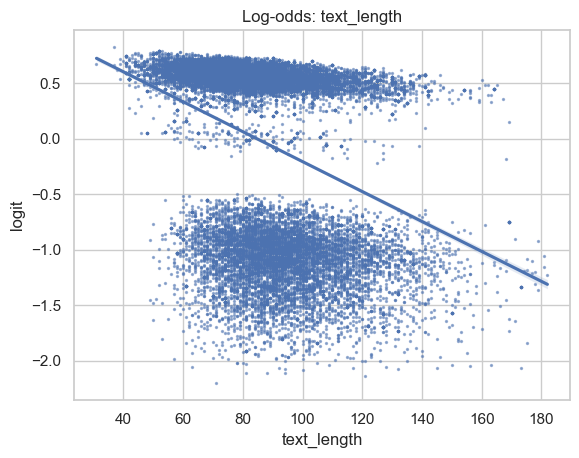

In [50]:
sns.regplot(x='text_length', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: text_length');

Results      
All show linearity   
linearity: points on the plot appear to fall along a straight line. If they do not, then model does not fit the data well.

## Results and evaluation
* get predictions on testing data
* get metrics: accuracy, precision, recall, and F1 score
* create confusion matrix
* create ROC curve
* create AUC

In [51]:
# Generate and save predictions on held out test data
y_preds = log_clf.predict(X_test)

In [52]:
y_preds

array([1, 0, 1, ..., 1, 1, 1])

In [53]:
y_test

26849    1
1227     0
25467    1
27310    1
27560    1
        ..
16315    0
19045    1
30024    1
17501    0
29483    1
Name: verified_status_verified, Length: 8942, dtype: int64

In [54]:
# Score the model (accuracy) on the test data
log_clf.score(X_test, y_test)

0.6785953925296354

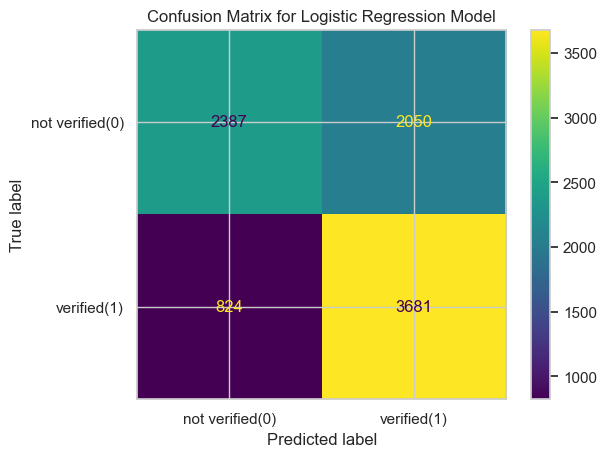

In [55]:
# Create confusion matrix to visualize accuracy of classifications of observations
log_cm = confusion_matrix(y_test, y_preds)

# Display confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm, display_labels=['not verified(0)', 'verified(1)'])

log_disp.plot()
plt.title('Confusion Matrix for Logistic Regression Model');

In [56]:
# Get shape of testing set
X_test.shape, y_test.shape

((8942, 10), (8942,))

*Legend*
* True label (y_test): actual labels of the holdout sample
* Predicted label (y_pred): predicted labels (not verified/verified) on the holdout test sample

Since this is a binomial logistic regression, there are only two labels:
* 0 = the person was labeled as not verified that observation
* 1 = a person was labeled as verified for that observation

*Translation*<br>
`True negatives`(UL): # of videos posted by not verified(0) authors that the model accurately predicted as not verified(0) = 2387   
`True positives`(LR): # of videos posted by verified(1) authors that the model accurately predicted as verified(1) = 3681   
`False positives`(UR)/Type I Errors: # of videos posted by not verified accounts(0) that the model predicted were verified(1) = 2050   
`False negatives`(LL)/Type II Errors: # of videos posted by verified accounts(1) that the model predicted were not verified(0) = 824   

Immediately seen from the model is a high proportion of `False positives`(UR) or Type I Errors where the model incorrectly predicted a video was posted by a verified author.

In [57]:
# Create table of results for metrics
models_table = pd.DataFrame({'Model': ['Logistic Regression'],
                      'Precision': ['%.6f' % precision_score(y_test, y_preds)],
                      'Recall': ['%.6f' % recall_score(y_test, y_preds)],
                      'Accuracy': ['%.6f' % accuracy_score(y_test, y_preds)],
                      'F1': ['%.6f' % f1_score(y_test, y_preds)]
                     },)
models_table

,Model,Precision,Recall,Accuracy,F1
0,Logistic Regression,0.642296,0.817092,0.678595,0.719226


In [58]:
# Create a more specific classification report
target_labels = ['not verified', 'verified']
print(classification_report(y_test,  y_preds, target_names = target_labels))

              precision    recall  f1-score   support

not verified       0.74      0.54      0.62      4437
    verified       0.64      0.82      0.72      4505

    accuracy                           0.68      8942
   macro avg       0.69      0.68      0.67      8942
weighted avg       0.69      0.68      0.67      8942



**Precision** measures the % of videos posted by verified authors(1) out of all videos predicted to be posted by verified authors(1) 

*The good*   
This model has a precision score of 0.642296, thus it is okay at predicting whether a video is post by a verified author(1) (true positives), based on the variables. In an effort to be precise, the model also attempts to reduce the occurrences of incorrectly classifying videos as coming from verified authors (1) when they are actually from not verified authors(0) (false positives/Type I errors).

**Recall** measures the % of videos posted by verified authors(1) that the classifier correctly identified as coming from verified authors(1) out of all verified(1) observations in the test set. 

*The good*      
This model has a recall score of 0.817092, thus it is rather good at correctly identifying whether a video is coming from a verified account(1), based on the available variables, out of all videos labelled as coming from verified accounts(1). The model is also less likely to miss videos coming from verified accounts(1). (false-negative/Type II errors).

*The bad*   
However, because the model is more sensitive to finding videos coming from verified authors(1), it can be prone to incorrectly categorizing verified(1) (false-positives/Type-I error) when they are not verified(0).

The conclusion:\
The high #(2050) of incorrectly classified as verified authors as demonstrated by the confusion matrix (Type I errors), suggests a fault with the model, even with the high recall score. The goal is to correctly locate not verified author videos.

**Accuracy** is the percentage of data points that were correctly classified out of all total predictions. 

*The good*    
The model achieved an accuracy score of 0.678595 demonstrating okay predictive power.

**F1 Score** (the harmonic mean) balances precision (minimizing false positives or Type I errors) and recall (minimizing false negatives or Type II errors) performance, providing a single value for evaluation.

The conclusion\
The combined F1 score of 0.719226 indicates that the model could likely be made more robust, particularly with the 54% recall score in identifying not verified authors.

#### Plot ROC and AOC
Visualize the performance of the logistic regression classifier

**ROC curve (receiver operating characteristic curve)**
* A ROC curse visualizes the performance of a classifier at different classification thresholds
* For binary classification: a classification threshold is a cutoff point for differentiating the positive class from the negative class
* y axis: True Positive Rate (Recall). The probability that model predicts a positive and it is negative (Sensitivity).
* X axis: False Positive Rate (= False Positives / (False Positives + True Negatives)). The probability that model predicts a negative and it is negative (Specificity)

**AUC (area under the ROC curve)**
* The AUC score provides an aggregate measure of performance of the model at each threshold.

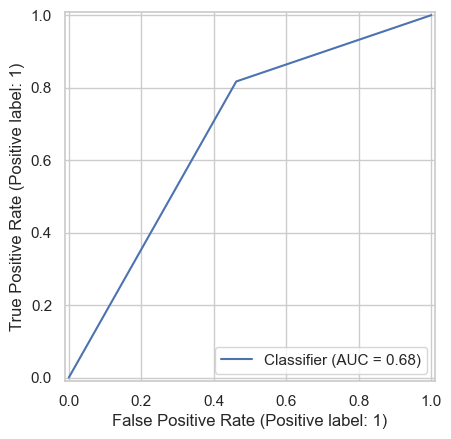

In [59]:
# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_preds)
plt.show()

In [60]:
# Compute the AUC
roc_auc_score(y_test,y_preds)

0.6775341149255191

*ROC curve*   
The graph shows of pairs (true positive/false positive) across all possible classification thresholds (classification decisions) and confirms that the model is only middling at classifying the data as the False Positive Rate going from a steep increase to a gradual one.

*AUC scores*    
This model has an AUC score of ~70%, which is in line with the ~72% F1 score, suggesting that the model has better overall performance (over all possible classification thresholds) in distinguishing between positive and negative classes.

In [61]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a df for readability
coefficients = pd.DataFrame(data={'Feature':log_clf.feature_names_in_, 'Coefficient':log_clf.coef_[0]})
coefficients

,Feature,Coefficient
0,video_duration_sec,-2.858508e-03
1,video_view_count,-6.121497e-07
2,video_share_count,1.553621e-05
3,likes_per_view,-4.524293e-01
4,comments_per_view,-2.021493e-03
5,shares_per_view,-6.144475e-02
6,text_length,-1.975691e-03
7,claim_status_opinion,1.523851e+00
8,author_ban_status_banned,-5.588932e-01
9,author_ban_status_under review,-2.228794e-01


In [62]:
coefficients = coefficients.sort_values(by='Coefficient', ascending=False).reset_index(drop=True).round(5)
coefficients

,Feature,Coefficient
0,claim_status_opinion,1.52385
1,video_share_count,0.00002
2,video_view_count,-0.00000
3,text_length,-0.00198
4,comments_per_view,-0.00202
5,video_duration_sec,-0.00286
6,shares_per_view,-0.06144
7,author_ban_status_under review,-0.22288
8,likes_per_view,-0.45243
9,author_ban_status_banned,-0.55889


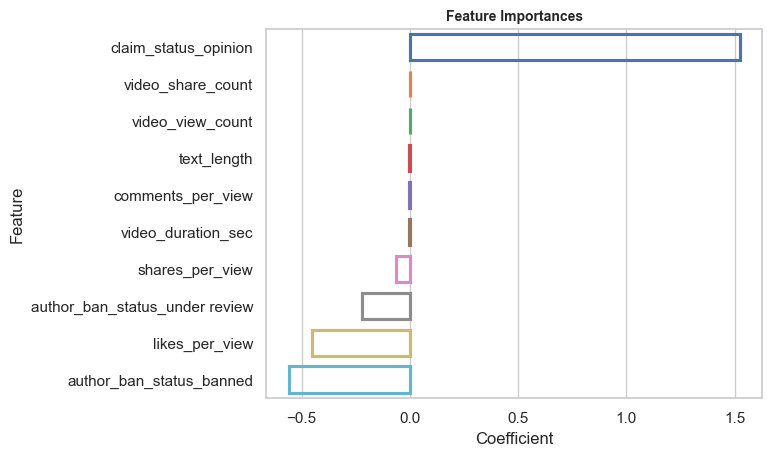

In [63]:
# Plot bar graph for feature importances
sns.barplot(data=coefficients, 
            x='Coefficient', 
            y='Feature', 
            hue = 'Feature', 
            fill=False,               # Outline only bars
            gap=.1                    # Create space between bars
           )
plt.title('Feature Importances',
          size=10, 
          weight='bold');             # Embolden font

Results\
In logistic regression, the coefficient for a binary variable represents *the change in the log-odds* of the outcome variable for a 1-unit change in the predictor variable. 

Here, the `claim_status_opinion` coefficient 1.52 (where claim = 0 and opinion = 1) means that moving from "claim" to "opinion" is associated with an increase in the log-odds (the probability of an event occurring) that the video is posted by a verified account (odds ratio 1.523851 units). This suggests that the presence of `claim_status_opinion` being an opinion is positively associated with the outcome variable being posted by a verified account.

Similarly, the coefficients for `author_ban_status_banned`(-0.55889) or `author_ban_status_under review`(-0.22288) were negatively correlated to the outcome that the video is posted by a verified account. Hardly a shocking conclusion.

Most helpful perhaps is the coefficient for `likes_per_view` (-0.45243) which suggests a negative correlation between likes and verification.

## See TikTok Executive Summary II for summary